<a href="https://colab.research.google.com/github/JaynthReddy91/MachineLearning/blob/main/ML_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MECE_Clustering_Experiment.py
# Complete Python implementation for MECE Clustering Ensemble

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer, load_iris, load_wine
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.model_selection import ParameterSampler
import random

# --------------------------
# 1. Load datasets
# --------------------------
datasets = {
    "BreastCancer": load_breast_cancer(),
    "Iris": load_iris(),
    "Wine": load_wine()
}

# --------------------------
# 2. Base Clustering Function
# --------------------------
def generate_base_clusterings(X, ensemble_size=10, n_clusters_range=(2,10)):
    clusterings = []
    for _ in range(ensemble_size):
        n_clusters = random.randint(n_clusters_range[0], n_clusters_range[1])
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=random.randint(0,100))
        labels = clusterer.fit_predict(X)
        clusterings.append(labels)
    return np.array(clusterings)

# --------------------------
# 3. Member Enhancement
# Split low-quality clusters & merge similar clusters
# --------------------------
def enhance_members(base_clusterings, X, split_threshold=0.3, merge_threshold=0.7, weight_metric="silhouette"):
    enhanced = []
    for labels in base_clusterings:
        # Calculate silhouette
        sil_score = silhouette_score(X, labels) if weight_metric=="silhouette" else None

        # Split clusters with low internal cohesion
        unique_labels = np.unique(labels)
        new_labels = labels.copy()
        for ul in unique_labels:
            indices = np.where(labels==ul)[0]
            if len(indices)<=1:
                continue
            # Check if there are at least 2 unique labels in the subset before calculating silhouette_score
            if len(np.unique(labels[indices])) > 1:
                sub_sil = silhouette_score(X[indices], np.zeros(len(indices))) if len(indices)>1 else 0
            else:
                sub_sil = 1.0  # Assign a high silhouette score to single-label clusters to avoid splitting

            if sub_sil < split_threshold:
                # Split into 2 clusters
                km = KMeans(n_clusters=2, random_state=42)
                split_labels = km.fit_predict(X[indices])
                new_labels[indices] = [max(new_labels)+sl+1 for sl in split_labels]

        # Merge similar clusters based on centroid distance
        unique_labels = np.unique(new_labels)
        centroids = [X[new_labels==ul].mean(axis=0) for ul in unique_labels]
        merged_labels = new_labels.copy()
        for i in range(len(centroids)):
            for j in range(i+1, len(centroids)):
                dist = np.linalg.norm(centroids[i]-centroids[j])
                if dist < merge_threshold:
                    merged_labels[merged_labels==unique_labels[j]] = unique_labels[i]

        enhanced.append(merged_labels)
    return np.array(enhanced)

# --------------------------
# 4. Weighted Consensus
# --------------------------
def consensus_clustering(enhanced_clusterings, weights=None):
    n_samples = enhanced_clusterings.shape[1]
    ensemble_size = enhanced_clusterings.shape[0]

    if weights is None:
        weights = np.ones(ensemble_size)

    # Simple voting-based consensus
    final_labels = []
    for i in range(n_samples):
        votes = {}
        for e in range(ensemble_size):
            lbl = enhanced_clusterings[e][i]
            votes[lbl] = votes.get(lbl,0) + weights[e]
        # Choose label with max votes
        final_labels.append(max(votes, key=votes.get))
    return np.array(final_labels)

# --------------------------
# 5. Hyperparameter Tuning
# --------------------------
param_grid = {
    "ensemble_size": [5,10,15],
    "split_threshold": [0.2,0.3,0.4],
    "merge_threshold": [0.5,0.6,0.7],
    "weight_metric": ["silhouette", "density"]
}

param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# --------------------------
# 6. Run Experiments
# --------------------------
results = []

for dname, dataset in datasets.items():
    X = dataset.data
    y_true = dataset.target

    best_ari = -1
    best_nmi = -1
    best_params = None

    for params in param_list:
        ensemble_size = params["ensemble_size"]
        split_threshold = params["split_threshold"]
        merge_threshold = params["merge_threshold"]
        weight_metric = params["weight_metric"]

        base_clusterings = generate_base_clusterings(X, ensemble_size)
        enhanced = enhance_members(base_clusterings, X, split_threshold, merge_threshold, weight_metric)
        final_labels = consensus_clustering(enhanced)

        ari = adjusted_rand_score(y_true, final_labels)
        nmi = normalized_mutual_info_score(y_true, final_labels)

        if ari > best_ari:
            best_ari = ari
            best_nmi = nmi
            best_params = params

    results.append({
        "Dataset": dname,
        "Best ARI": best_ari,
        "Best NMI": best_nmi,
        "Best Params": best_params
    })

# --------------------------
# 7. Display Results
# --------------------------
results_df = pd.DataFrame(results)
print(results_df)

        Dataset  Best ARI  Best NMI  \
0  BreastCancer  0.519739  0.427071   
1          Iris  0.677900  0.737018   
2          Wine  0.325824  0.387119   

                                         Best Params  
0  {'weight_metric': 'silhouette', 'split_thresho...  
1  {'weight_metric': 'density', 'split_threshold'...  
2  {'weight_metric': 'density', 'split_threshold'...  


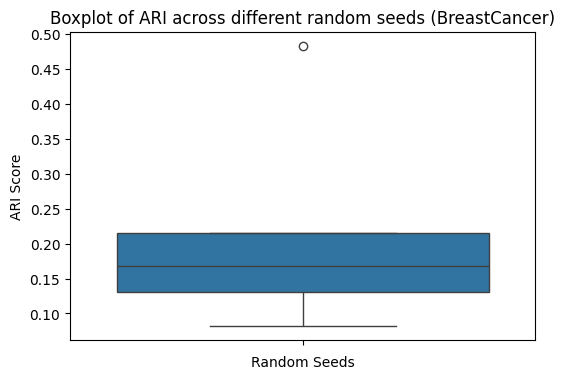

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: run MECE multiple times with same hyperparameters but different random seeds
dataset_name = "BreastCancer"
X = datasets[dataset_name].data
y_true = datasets[dataset_name].target

ari_scores = []
seeds = [10, 20, 30, 40, 50]

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    base_clusterings = generate_base_clusterings(X, ensemble_size=10, n_clusters_range=(2,10))
    enhanced = enhance_members(base_clusterings, X, split_threshold=0.3, merge_threshold=0.6, weight_metric="silhouette")
    final_labels = consensus_clustering(enhanced)
    ari = adjusted_rand_score(y_true, final_labels)
    ari_scores.append(ari)

# Plot boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=ari_scores)
plt.title(f"Boxplot of ARI across different random seeds ({dataset_name})")
plt.ylabel("ARI Score")
plt.xlabel("Random Seeds")
plt.show()


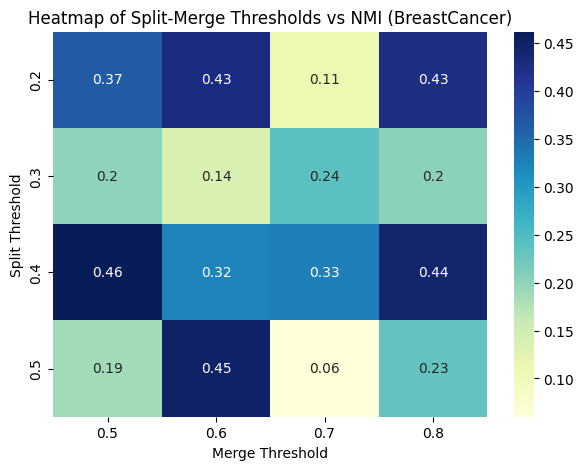

In [ ]:
# Define range of hyperparameters to test
split_values = [0.2, 0.3, 0.4, 0.5]
merge_values = [0.5, 0.6, 0.7, 0.8]

nmi_matrix = np.zeros((len(split_values), len(merge_values)))

for i, split_thr in enumerate(split_values):
    for j, merge_thr in enumerate(merge_values):
        base_clusterings = generate_base_clusterings(X, ensemble_size=10, n_clusters_range=(2,10))
        enhanced = enhance_members(base_clusterings, X, split_threshold=split_thr, merge_threshold=merge_thr, weight_metric="silhouette")
        final_labels = consensus_clustering(enhanced)
        nmi = normalized_mutual_info_score(y_true, final_labels)
        nmi_matrix[i,j] = nmi

# Plot heatmap
plt.figure(figsize=(7,5))
sns.heatmap(nmi_matrix, annot=True, xticklabels=merge_values, yticklabels=split_values, cmap="YlGnBu")
plt.xlabel("Merge Threshold")
plt.ylabel("Split Threshold")
plt.title(f"Heatmap of Split-Merge Thresholds vs NMI ({dataset_name})")
plt.show()
